In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
def smooth_data(scores, smoothness=20):
    if smoothness is None:
        return scores

    smooth_scores = np.zeros((scores.shape[0] - smoothness, scores.shape[1]))
    for i in range(scores.shape[1]):
        for j in range(smooth_scores.shape[0]):
            smooth_scores[j,i] = np.mean(scores[j : j + smoothness, i])
    # smooth_scores = np.zeros(scores.shape)
    # for i in range(scores.shape[1]):
    #     smooth_scores[:, i] = np.convolve(scores[:, i], np.ones(smoothness)/smoothness, "same")

    return smooth_scores

def plot(all_scores, plot_settings, save_file, smoothness=20):
    x = np.arange(len(all_scores[0]) - smoothness)
    for i, scores in enumerate(all_scores):
        smooth_scores = smooth_data(scores, smoothness=smoothness)
        plt.plot(x, smooth_scores, label=plot_settings[i]["label"])
    plt.legend(loc="upper left")
    # plt.savefig(save_file)

def get_mean_ste(scores):
    scores_mean = np.mean(scores, axis=1)
    scores_ste = np.std(scores, axis=1) / np.sqrt(scores.shape[1])
    return scores_mean, scores_ste
    

## FTA vs ReLU

In [30]:
data_dir = "/home/gohar/RL1/RL1-Project/data/ftavreluvlarge"

df_dict = {}

for file in os.listdir(data_dir):
    # Reading data from CSV    
    df = pd.read_csv(os.path.join(data_dir,file), skiprows=5)
    scores = np.expand_dims(np.asarray(df["Score"]), 1)
    steps = np.asarray(df["Step"])
    
    # Reading FTA params from file name
    activation = file.split("_")[0]
    target = file.split("_")[1].split("t")[1]
    
    # Populating fta dict
    if activation not in df_dict.keys():
        df_dict[activation] = {}

    if target not in df_dict[activation].keys():
        df_dict[activation][target] = {"scores": scores,
                                        "steps": steps,
                                        "runs": 1}
    else:
        if scores.shape[0] != df_dict[activation][target]["scores"].shape[0]:
            continue
        df_dict[activation][target]["scores"] = \
            np.concatenate((df_dict[activation][target]["scores"], scores), axis = 1) 
        df_dict[activation][target]["runs"] = df_dict[activation][target]["runs"] + 1

# pprint(fta_dict, depth =2, indent = 2)
for activation in sorted(df_dict.keys()):
    print(f"{activation}:")
    string = ""
    for target in sorted(df_dict[activation].keys()):
        string  = string + f"\t{target}: runs: {df_dict[activation][target]['runs']}"
    print(string)


fta:
	False: runs: 10	True: runs: 10
ftabest:
	False: runs: 10
relu:
	False: runs: 10	True: runs: 10
relularge:
	False: runs: 10	True: runs: 10


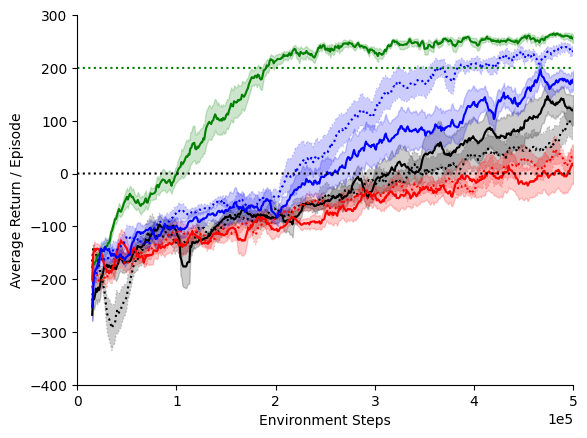

In [31]:
which_scores = "scores" # "avg_scores" or "scores"
smoothness = 10 # int or None
include_ftabest = True

for i, activation in enumerate(sorted(df_dict.keys())):
    if not include_ftabest and activation == "ftabest":
        continue
    for target in sorted(df_dict[activation].keys()):
        runs = df_dict[activation][target]["runs"]
        if runs < 10:
            continue
        
        # smoothing scores for each run and calculating mean and ste
        scores = df_dict[activation][target][which_scores]
        smooth_scores = smooth_data(scores, smoothness)
        scores_mean, scores_ste = get_mean_ste(smooth_scores)
        
        x_start_index = df_dict[activation][target]["steps"].shape[0] - smooth_scores.shape[0]
        x = df_dict[activation][target]["steps"][x_start_index:]

        if activation == "fta":
            color = "k"
        elif activation == "ftabest":
            color = "g"
        elif activation == "relu":
            color = "r"
        else:
            color = "b"
        style = ":" if target =="True" else "-"
        target_label = "with_target" if target =="True" else "wo_target"
        plt.plot(x, scores_mean, f"{color}{style}", label=f"{activation}_{target_label}")
        plt.fill_between(x, scores_mean+scores_ste, scores_mean-scores_ste, alpha=0.2, color=color, linestyle=style)
# plt.legend(loc="upper left")
plt.plot(np.zeros(500000), "k:")
plt.plot(np.zeros(500000)+200, "g:")
# plt.title("FTA vs ReLU")
plt.ylim([-400, 300])
plt.xlim([0, 500000])
# plt.grid()
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.set_xlabel("Environment Steps")
ax.set_ylabel("Average Return / Episode")
plt.show()


## FTA Hyperparameter Sweep

### Reading CSVs

In [6]:
data_dir = "/home/gohar/RL1/RL1-Project/data/ftasweep"
file_prefix = "fta"

fta_dict = {}
for file in os.listdir(data_dir):
    if file.split("_")[0] != file_prefix:
        continue

    # Reading data from CSV    
    df = pd.read_csv(os.path.join(data_dir,file), skiprows=5)
    scores = np.expand_dims(np.asarray(df["Score"]), 1)
    steps = np.asarray(df["Step"])
    # avg_scores = np.expand_dims(np.asarray(df["Average Score:"]), 1)
    
    # Reading FTA params from file name
    upper_limit = float(file.split('u')[1].split("_")[0])
    delta = float(file.split('d')[1].split("_")[0])
    num_tiles = round(2*upper_limit/delta)
    if num_tiles == 16:
        continue

    # Populating fta dict
    if num_tiles not in fta_dict.keys():
        fta_dict[num_tiles] = {}
    if upper_limit not in fta_dict[num_tiles].keys():
        fta_dict[num_tiles][upper_limit] = {"scores": scores,
                                            "steps": steps,
                                            "runs": 1}
    else:
        if scores.shape[0] != fta_dict[num_tiles][upper_limit]["scores"].shape[0]:
            # print(upper_limit, num_tiles, delta, file.split("_")[-1])
            continue
        fta_dict[num_tiles][upper_limit]["scores"] = \
            np.concatenate((fta_dict[num_tiles][upper_limit]["scores"], scores), axis = 1) 
        # fta_dict[upper_limit][num_tiles]["avg_scores"] = \
        #     np.concatenate((fta_dict[upper_limit][num_tiles]["avg_scores"], avg_scores), axis = 1)
        fta_dict[num_tiles][upper_limit]["runs"] = fta_dict[num_tiles][upper_limit]["runs"] + 1

# pprint(fta_dict, depth =2, indent = 2)
for num_tiles in sorted(fta_dict.keys()):
    print(f"{num_tiles}:")
    string = ""
    for upper_limit in sorted(fta_dict[num_tiles].keys()):
        string  = string + f"\t{upper_limit}: runs: {fta_dict[num_tiles][upper_limit]['runs']}"
    print(string)


20:
	0.01: runs: 10	0.1: runs: 10	1.0: runs: 10	10.0: runs: 10	50.0: runs: 10	100.0: runs: 10
64:
	0.01: runs: 10	0.1: runs: 10	1.0: runs: 10	10.0: runs: 10	50.0: runs: 10	100.0: runs: 10
128:
	0.01: runs: 10	0.1: runs: 10	1.0: runs: 10	10.0: runs: 10	50.0: runs: 10	100.0: runs: 10


### Plotting

Text(0.09, 0.5, 'Average Return / Episode')

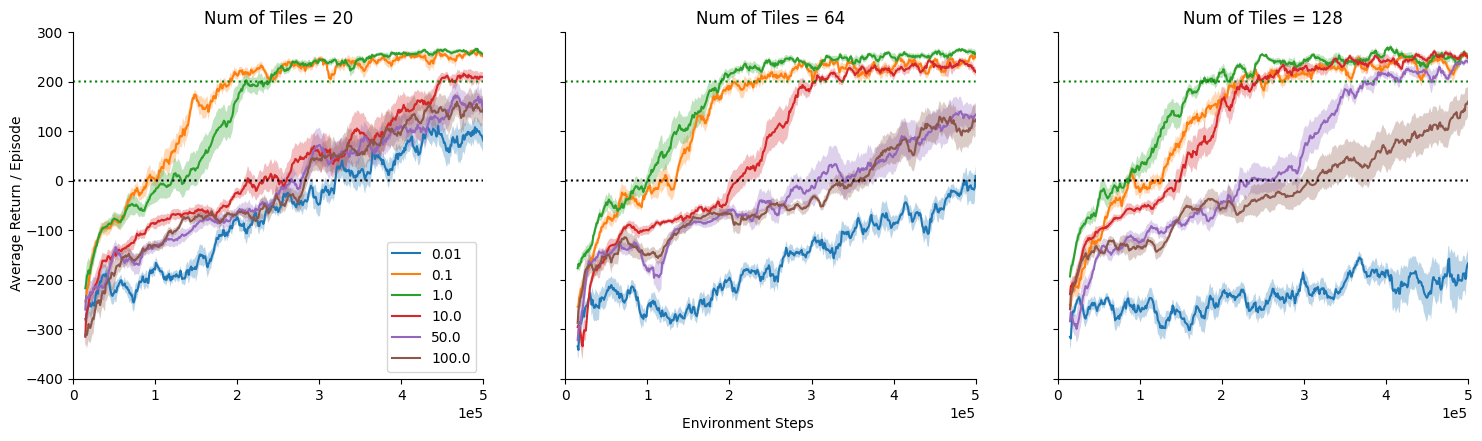

In [7]:
plots_in_onerow = 3
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 4.5))
which_scores = "scores" # "avg_scores" or "scores"
smoothness = 10 # int or None

for i, num_tiles in enumerate(sorted(fta_dict.keys())):
    for j, upper_limit in enumerate(sorted(fta_dict[num_tiles].keys())):
        runs = fta_dict[num_tiles][upper_limit]["runs"]
        if runs < 10:
            continue
        
        # smoothing scores for each run and calculating mean and ste
        scores = fta_dict[num_tiles][upper_limit][which_scores]
        smooth_scores = smooth_data(scores, smoothness)
        scores_mean, scores_ste = get_mean_ste(smooth_scores)
        
        x_start_index = fta_dict[num_tiles][upper_limit]["steps"].shape[0] - smooth_scores.shape[0]
        x = fta_dict[num_tiles][upper_limit]["steps"][x_start_index:]

        # ax = ax[int(i/plots_in_onerow), i%plots_in_onerow]
        ax = axs[i]
        ax.plot(x, scores_mean, label=upper_limit)
        ax.fill_between(x, scores_mean+scores_ste, scores_mean-scores_ste, alpha=0.3)
        ax.set_title(f"Num of Tiles = {num_tiles}")

for i, ax in enumerate(axs):
    if i == 0:
        ax.legend(loc="lower right")
    # ax.grid(axis="y")
    ax.set_ylim([-400, 300])
    ax.set_xlim([0, 500000])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.plot(np.zeros(500000), "k:")
    ax.plot(np.zeros(500000)+200, "g:")
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
fig.text(0.5, 0.0, 'Environment Steps', ha='center')
fig.text(0.09, 0.5, 'Average Return / Episode', va='center', rotation='vertical')

## FTA Tanh Norm

In [33]:
data_dir = "/home/gohar/RL1/RL1-Project/data/fta_tanh_rangenorm"

df_dict = {}

for file in os.listdir(data_dir):
    # Reading data from CSV    
    df = pd.read_csv(os.path.join(data_dir,file), skiprows=5)
    scores = np.expand_dims(np.asarray(df["Score"]), 1)
    steps = np.asarray(df["Step"])
    
    # Reading FTA params from file name
    if "n" not in file:
        activation = "fta"
    else:
        activation = file.split("_")[2][1:]
    upper_bound = float(file.split("u")[1].split("_")[0])
    delta = float(file.split('d')[1].split("_")[0])
    num_tiles = round(2*upper_bound/delta)
    if num_tiles != 20:
        print(file, num_tiles, upper_bound, delta, floatfile.split("u")[1].split("_")[0])
    # Populating fta dict
    if upper_bound not in df_dict.keys():
        df_dict[upper_bound] = {}

    if activation not in df_dict[upper_bound].keys():
        df_dict[upper_bound][activation] = {"scores": scores,
                                        "steps": steps,
                                        "runs": 1}
    else:
        if scores.shape[0] != df_dict[upper_bound][activation]["scores"].shape[0]:
            continue
        df_dict[upper_bound][activation]["scores"] = \
            np.concatenate((df_dict[upper_bound][activation]["scores"], scores), axis = 1) 
        df_dict[upper_bound][activation]["runs"] = df_dict[upper_bound][activation]["runs"] + 1

# pprint(fta_dict, depth =2, indent = 2)
for upper_bound in sorted(df_dict.keys()):
    print(f"{upper_bound}:")
    string = ""
    for activation in sorted(df_dict[upper_bound].keys()):
        string  = string + f"\t{activation}: runs: {df_dict[upper_bound][activation]['runs']}"
    print(string)


0.01:
	batchnorm: runs: 10	fta: runs: 10	rangenorm: runs: 10	tanh: runs: 10
1.0:
	fta: runs: 10	rangenorm: runs: 10	tanh: runs: 10
100.0:
	batchnorm: runs: 10	fta: runs: 10	rangenorm: runs: 10	tanh: runs: 10


Text(0.09, 0.5, 'Average Return / Episode')

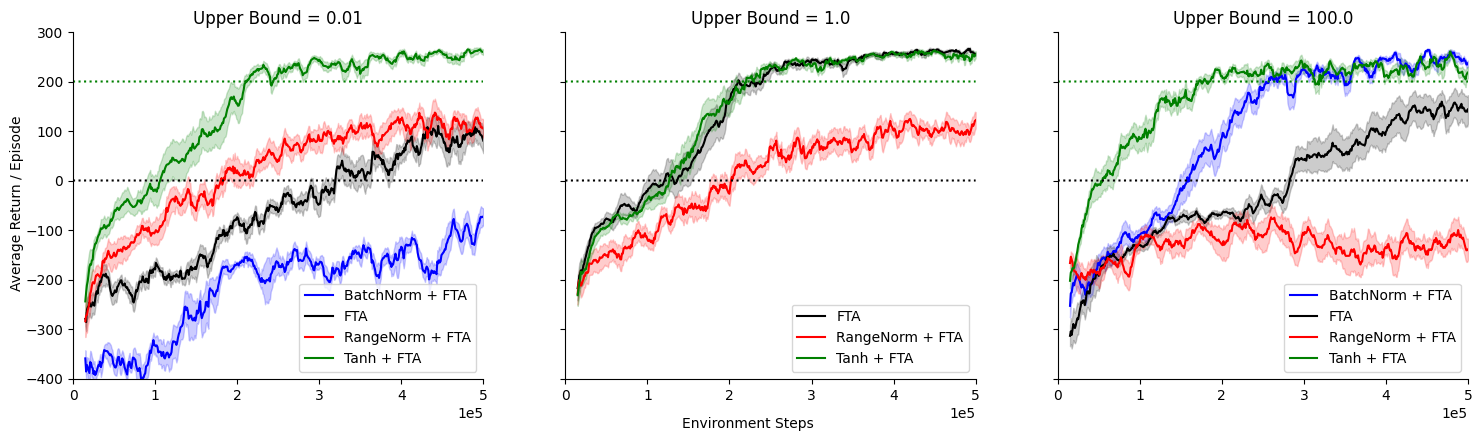

In [38]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 4.5))
which_scores = "scores" # "avg_scores" or "scores"
smoothness = 10 # int or None
include_ftabest = True

for i, upper_bound in enumerate(sorted(df_dict.keys())):
    for activation in sorted(df_dict[upper_bound].keys()):
        runs = df_dict[upper_bound][activation]["runs"]
        if runs < 10:
            continue
        
        # smoothing scores for each run and calculating mean and ste
        scores = df_dict[upper_bound][activation][which_scores]
        smooth_scores = smooth_data(scores, smoothness)
        scores_mean, scores_ste = get_mean_ste(smooth_scores)
        
        x_start_index = df_dict[upper_bound][activation]["steps"].shape[0] - smooth_scores.shape[0]
        x = df_dict[upper_bound][activation]["steps"][x_start_index:]

        ax = axs[i]
        if activation == "fta":
            color = "k"
            act_label = "FTA"
        elif activation == "tanh":
            color = "g"
            act_label = "Tanh + FTA"
        elif activation == "rangenorm":
            color = "r"
            act_label = "RangeNorm + FTA"
        else:
            color = "b"
            act_label = "BatchNorm + FTA"
        ax.plot(x, scores_mean, f"-{color}", label=f"{act_label}")
        ax.fill_between(x, scores_mean+scores_ste, scores_mean-scores_ste, alpha=0.2, color=color)
        ax.set_title(f"Upper Bound = {upper_bound}")

for i, ax in enumerate(axs):
    # if i == 0:
    ax.legend(loc="lower right")
    # ax.grid(axis="y")
    ax.set_ylim([-400, 300])
    ax.set_xlim([0, 500000])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.plot(np.zeros(500000), "k:")
    ax.plot(np.zeros(500000)+200, "g:")
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
fig.text(0.5, 0.0, 'Environment Steps', ha='center')
fig.text(0.09, 0.5, 'Average Return / Episode', va='center', rotation='vertical')